**Programming Exercise 1**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsRegressor

np.random.seed(0)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                  

In [2]:
class KFold:
    
    def __init__(self, k=5):
        self.k = k
        
    def split(self, X_train, shuffle=False):
        N = X_train.shape[0]
        
        if self.k == -1:
            self.k = N
        elif self.k < 2 or self.k > N:
            raise Exception('The number of splits is not in the interval [2, set_size]')
        
        indices = np.arange(N)
        
        if shuffle:
            indices = np.random.permutation(indices)
        
        splits = np.array_split(indices, self.k)
        
        splits_result = list()

        for i, test_split_indices in enumerate(splits):

            train_split_indices = np.take(splits, [index for index in range(len(splits)) if index != i], axis=0)
            train_split_indices = np.ravel(np.hstack(train_split_indices))
            
            test_split_indices = np.ravel(np.hstack(test_split_indices))
            
            splits_result.append((train_split_indices, test_split_indices))
        
        return splits_result
    
    def get_n_splits(self):
        return self.k

In [3]:
class LeaveOneOut(KFold):
    
    def __init__(self):
        super().__init__(k=-1)

In [4]:
def mean_squared_error(y_true, y_pred, squared=True):
    if y_pred.shape != y_true.shape:
        raise Exception('Input shapes do not match')
        
    mse = np.power(y_true - y_pred, 2).mean()
    
    if squared:
        return mse
    
    return np.sqrt(mse)

In [5]:
def train_test_split(X, y, train_size, shuffle=False):
    N = X.shape[0]
    split_index = 0
    
    indices = np.arange(N)
    
    if shuffle:
        indices = np.random.permutation(indices)
        
    if isinstance(train_size, int):
        if train_size < 0 or train_size > N - 2:
            raise Exception('Training set size is not valid')
        
        split_index = train_size
    elif isinstance(train_size, float):
        if train_size < 0 or train_size > 1:
            raise Exception('Training set size is not valid')
        
        split_index = int(train_size * N)
    
    X_train = np.take(X, indices[:split_index]).reshape(-1, 1)
    y_train = np.take(y, indices[:split_index]).reshape(-1, 1)
    
    X_test = np.take(X, indices[split_index:]).reshape(-1, 1)
    y_test = np.take(y, indices[split_index:]).reshape(-1, 1)
        
    return X_train, X_test, y_train, y_test

In [6]:
def cross_val_score(estimator, X, y=None, cv=None, shuffle=False):
    splits = None
    
    if cv is None or isinstance(cv, int):
        # Set cv to be a KFold instance with number of splits set to cv
        cv = KFold(cv)
    elif type(cv) is tuple:
        # Set splits to be the tuple provided as argument
        splits = cv
    elif not (isinstance(cv, KFold) or isinstance(cv, LeaveOneOut)):
        raise Exception('Cross validation object cannot be used')

    scores = list()
    
    if splits is None:
        # Iterate over splits retrieved from instance of CV
        for train, test in cv.split(X, shuffle=shuffle):
            # Calculate error for each train and test split
            X_train_split = np.take(X, train).reshape(-1, 1)
            y_train_split = np.take(y, train).reshape(-1, 1)

            X_test_split = np.take(X, test).reshape(-1, 1)
            y_test_split = np.take(y, test).reshape(-1, 1)

            estimator.fit(X_train_split, y_train_split)

            y_pred_split = estimator.predict(X_test_split)
            
            scores.append(mean_squared_error(y_test_split, y_pred_split))
    else:
        # Retrieve splits from already calculated tuple
        X_train_split, X_test_split, y_train_split, y_test_split = splits
        
        estimator.fit(X_train_split, y_train_split)

        y_pred_split = estimator.predict(X_test_split)
        
        scores.append(mean_squared_error(y_test_split, y_pred_split))
        
    return np.array(scores, dtype=object)

In [7]:
N = 51
mean = 0.0
stdev = 1.15
np.random.seed(111)

In [8]:
X = np.linspace(-4, 4, N).reshape(-1, 1)
y = np.zeros(N).reshape(-1, 1)

epsilon = np.random.normal(mean, stdev, N).reshape(-1, 1)

y = np.power(X, 2) + epsilon

In [9]:
max_n_neighbors = 20
train_set_size = 40
k = 10
iterations = 5

In [10]:
model = KNeighborsRegressor()

kf = KFold(k=k)
loo = LeaveOneOut()

x_plot_ticks = np.arange(1, max_n_neighbors + 1)

# Keep track of scores for each iteration of CV approaches
it_mean_cv_scores_loo = list()
it_mean_cv_scores_kf = list()
it_mean_cv_scores_validation_set = list()

for iteration in range(iterations):
    # Produce permutation of the data for the iteration
    X_it, y_it = np.hsplit(np.random.permutation(np.append(X, y, axis=1)), [X.shape[1]])
    
    # Keep track of scores for each fitted model and approach
    mean_cv_scores_loo = list()
    mean_cv_scores_kf = list()
    mean_cv_scores_validation_set = list()
    
    for n_neighbors in range(1, max_n_neighbors + 1):
        # Set neighborhood size
        model.set_params(n_neighbors=n_neighbors)
        
        # Calculate scores using Leave One Out CV
        scores = cross_val_score(model, X_it, y_it, cv=loo)
        
        mean_cv_scores_loo.append(scores.mean())
        
        # Calculate scores using K-Fold CV
        scores = cross_val_score(model, X_it, y_it, cv=kf)
        
        mean_cv_scores_kf.append(scores.mean())
        
        # Calculate scores using 
        scores = cross_val_score(model, X_it, y_it, cv=train_test_split(X_it, y_it, train_set_size))
        
        mean_cv_scores_validation_set.append(scores.mean())
    
    it_mean_cv_scores_loo.append(mean_cv_scores_loo)
    it_mean_cv_scores_kf.append(mean_cv_scores_kf)
    it_mean_cv_scores_validation_set.append(mean_cv_scores_validation_set)

In [11]:
# Arguments for plotting the curves
its_scores = [it_mean_cv_scores_loo, it_mean_cv_scores_kf, it_mean_cv_scores_validation_set]
cv_approaches = ['Leave One Out CV', '10-Fold CV', 'Validation Set CV']
line_styles = ['r', 'g', 'b']
alphas = [0.4, 0.4, 0.4]

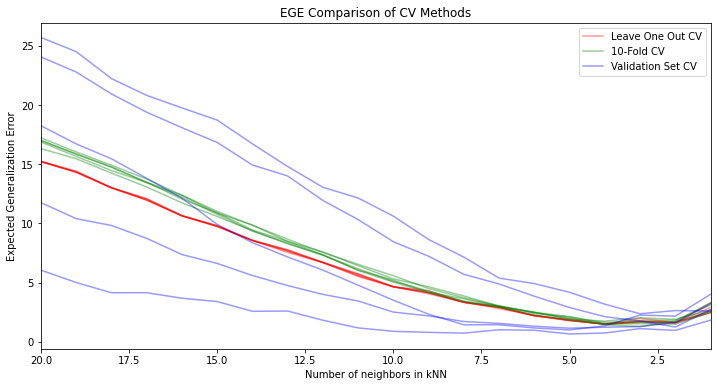

In [12]:
plt.figure(figsize=(12, 6))

for it_scores, cv_approach, line_style, alpha in zip(its_scores, cv_approaches, line_styles, alphas):
    for i, iteration_scores in enumerate(it_scores):
        plt.plot(x_plot_ticks, np.array(iteration_scores, dtype=object), line_style, alpha=alpha, label=cv_approach if i == 0 else None)

plt.xlim(max_n_neighbors, 1)

plt.title('EGE Comparison of CV Methods')

plt.xlabel('Number of neighbors in kNN')
plt.ylabel('Expected Generalization Error')

plt.legend()
plt.show()